In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.ticker as mticker

In [2]:
from plot_config import *

In [3]:
just_for_time = '/sciserver/filedb10-01/ocean/wenrui_temp/vol_budget'

rtime = np.array(xr.open_zarr(just_for_time).time)

/home/wjiang33/miniconda3/envs/bubblebath/lib/python3.12/site-packages/gribapi/__init__.py:23: UserWarning: ecCodes 2.38.0 or higher is recommended. You are running version 2.23.0
  warnings.warn(


In [4]:
projection = ccrs.Stereographic(central_longitude=-40.0)

In [5]:
xg = np.load('plotting_xg.npy')
yg = np.load('plotting_yg.npy')

In [6]:
ecco_grid = xr.open_zarr('~/ECCO_transport')

In [16]:
def create_line_plot(axs,case,traj_typ,ylim = (-0.23,0.07)):
    pre = f'lineplotprep/{case}_{traj_typ}_traj_'
    time_slice = slice(1824,None,-1)
    str_slc = str(time_slice)
    
    if case == 'salty':
        NUMBER_OF_PARTICLE,idate = 50109,salty_idate
    elif case == 'fresh':
        NUMBER_OF_PARTICLE,idate = 49998,fresh_idate
    else:
        NUMBER_OF_PARTICLE = 45336
        if '2012' in case:
            idate = 7365
        elif '2001' in case:
            idate = 3561

    if traj_typ == 'mean':
        the_term_dic = term_dic
        the_color_dic = color_dic_mean
    else:
        the_term_dic = case_term_dic
        the_color_dic = color_dic
    mean = xr.open_zarr(pre+'mean'+str_slc)
    std = xr.open_zarr(pre+'std'+str_slc)
    xtime = rtime[idate:idate-len(mean.time):-1]
    
    handles = []
    labels = []
    for var in rhs_list:
        # print(var)
        a_mean = -mean[var][::-1]
        a_std = std[var][::-1]/np.sqrt(NUMBER_OF_PARTICLE-1)
        print(var,float(a_mean[0]))
        mean_line, = axs.plot(xtime, a_mean, label=the_term_dic[var], color=the_color_dic[var])
        spread_area = axs.fill_between(xtime, a_mean - a_std, a_mean + a_std, alpha=0.3, label=the_term_dic[var], color=the_color_dic[var])
        handles.append((mean_line, spread_area))
        labels.append(the_term_dic[var])
    mean['tot'] = (mean['A']+mean['e_ua']+mean['E']+mean['dif_h']+mean['dif_v']+mean['I']+mean['F'])
    offset = float(mean['sf'][0])
    salt = np.diff(np.array([0]+list(mean['sl'].data)))
    to_explain = salt - offset
    error = to_explain + mean['tot']
    mean_line, = axs.plot(xtime, error[::-1], color=error_color)
    handles.append(mean_line)
    labels.append('Error')
    axs.set_ylabel('Cumulative Change (PSU)',fontsize = 7)
    ax2 = axs.twinx()
    ax2.set_ylabel('Salinity Anomaly (PSU)',fontsize = 7)
    ax2.tick_params('both',labelsize = 6)
    ax2.set_ylim(ylim[0] + offset, ylim[1] + offset)
    if case == 'salty':
        sal_color = salty_theme_color
    elif case == 'fresh':
        sal_color = fresh_theme_color
    else:
        sal_color = 'k'
    salt_line, = axs.plot(xtime, salt[::-1]-offset,color = sal_color)
    print('salt',float(salt[-1]),offset)
    handles.append(salt_line)
    labels.append('Salinity Anomaly')
    # invisible_line, = plt.plot([],[],c = 'none')
    
    # ylim = axs.get_ylim()
    # axs.fill_betweenx(ylim,[xfill[case][0]]*2,[xfill[case][1]]*2,**fill_betweenx_kwarg)
    axs.set_ylim(*ylim)
    axs.set_xlabel('Year',fontsize = 7)
    axs.tick_params(labelsize=6) 
    return labels,handles

A 0.04017624488013729
F -0.01995369487912323
dif_v -0.03836155681301246
E 0.006703700014646485
dif_h 0.013629858278472726
e_ua -0.0003860540462643693
I 0.004175933639460184
salt -0.0008396260608858341 -0.014363842168968438


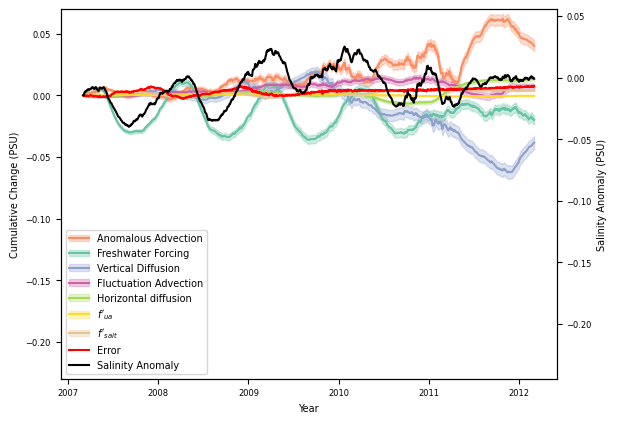

In [25]:
ax = plt.axes()
labels,handles = create_line_plot(ax,'neutral2012','mean',ylim = (-0.23,0.07))
ax.legend(handles,labels,fontsize = 7)

In [9]:
vmax = 50
def plot2d(maps,var,vol_each,ax = None,vmax = vmax,title = False, hash_type = 'wholedepth',
           ind = 0,subplot_offset = -0.12,fontsize = 7):
    # extent = (-95, 15, -10, 90)
    sp = -maps[var].sum(dim = 'Z')
    if hash_type == 'wholedepth':
        # pass
        ct = maps['count'].sum(axis = 0)/2
    else:
        ct = maps['count'][0]/2
    condition = np.logical_and(True, ct<5e2)
    to_plot = sp*vol_each/ecco_grid.rA
    zm = np.ma.masked_where(condition,to_plot)
    for i in [1,2,6,7,10,11]:
        p2 = ax.pcolormesh(xg[i] ,yg[i] ,to_plot[i] ,vmax = vmax,vmin = -vmax,cmap = balance, 
                           transform = ccrs.PlateCarree(),linewidth=0,rasterized=True)
        p2.set_edgecolor('face')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    ax.add_patch(Rectangle((xlim[0], ylim[0]), xlim[1]-xlim[0], ylim[1]-ylim[0], fill=False, hatch='..'))
    for i in [1,2,6,7,10,11]:
        p2 = ax.pcolormesh(xg[i] ,yg[i] ,zm[i] ,vmax = vmax,vmin = -vmax,cmap = balance, 
                           transform = ccrs.PlateCarree(),linewidth=0,rasterized=True)
        p2.set_edgecolor('face')
    ax.add_feature(cfeature.LAND, zorder=9, facecolor='grey')
    cbar = plt.colorbar(p2,extend = 'both')
    cbar.ax.set_ylabel(r'$psu\cdot m$', fontsize=fontsize,va = 'center')
    
    ax.set_extent([-90,0,88,10],crs = ccrs.PlateCarree())
    if title:
        ax.set_title(title,fontsize = fontsize)
        ax.set_title('('+chr(97+ind)+')',loc = 'left',x = subplot_offset,fontsize = fontsize)
    gl = ax.gridlines(draw_labels={"bottom": "x", "left": "y"}, linestyle="--", linewidth=0.5,zorder = 10)
    gl.xlocator = mticker.FixedLocator(np.arange(-4,1)*20)
    gl.y_inline = False
    # gl.x_inline = False
    gl.xlabel_style = {"fontsize": 5}
    gl.ylabel_style = {"fontsize": 5}

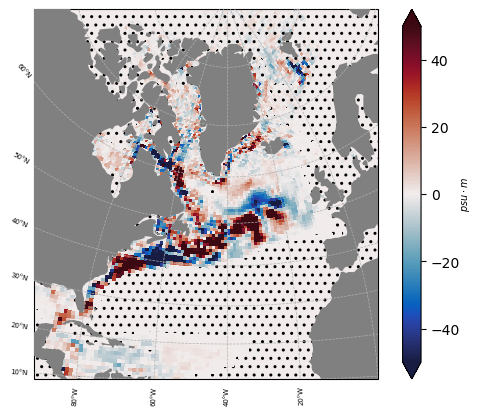

In [10]:
# vol_each = TOTAL_VOLUME_whole_domain/45336
case = 'neutral2012'
traj_typ = 'mean'
if 'fresh' in case:
    node = 4
else:
    node = 8
maps = xr.open_zarr(f'/sciserver/filedb0{node}-01/ocean/wenrui_temp/particle_file/{case}/{traj_typ}_traj_maps/')
ax = plt.axes(projection = projection)
vol_each = 558514510387999.06/45336
plot2d(maps,'A',vol_each,ax = ax,vmax = vmax)

In [11]:
mm = 1/25.4

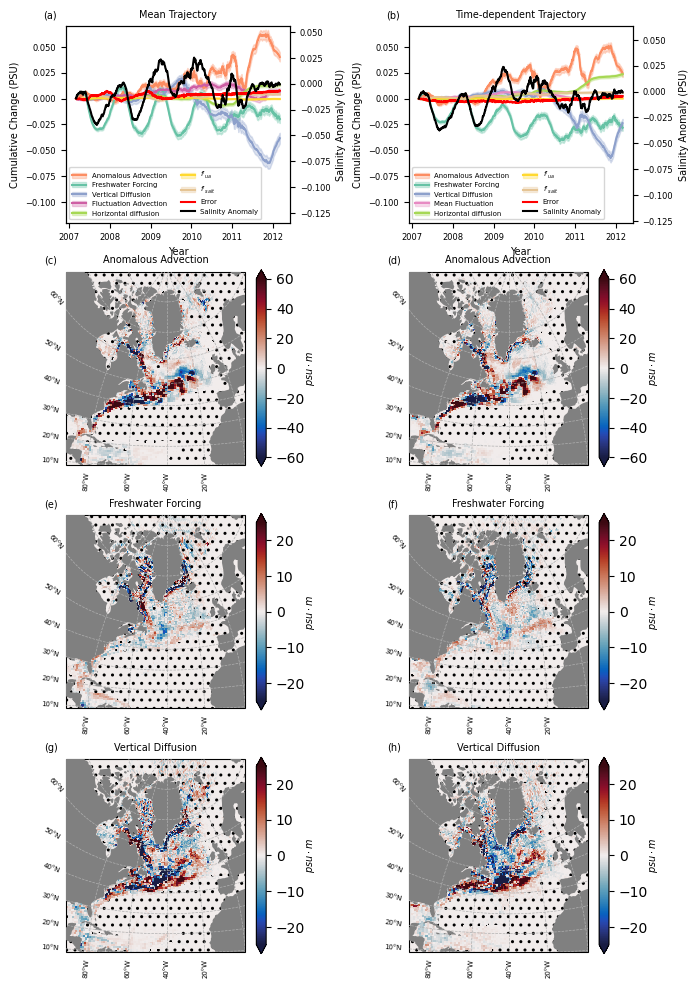

In [12]:
fig = plt.figure(figsize = (180*mm,254*mm))
axs = [
    plt.subplot(4,2,i+1) for i in range(2)
      ]+[
    plt.subplot(4,2,i+1, projection = projection) for i in range(2,8)
      ]
case = 'neutral2012'
if 'fresh' in case:
    node = 4
else:
    node = 8
vol_each = 558514510387999.06/45336

for i,traj_typ in enumerate(['mean','time']):
    labels,handles = create_line_plot(axs[i],case,traj_typ,ylim = (-0.12,0.07))
    axs[i].legend(handles,labels,fontsize = 5,ncol = 2)
    axs[i].set_title(f'({chr(97+i)})',loc = 'left',x = -0.1,fontsize = 7)
    axs[i].set_title(['Mean Trajectory','Time-dependent Trajectory'][i],fontsize = 7)

for j,traj_typ in enumerate(['mean','time']):
    for i,var in enumerate(['A','F','dif_v']):
        hash_type = 'wholedepth'
        vmax = 25
        if var == 'F':
            hash_type = 'surface'
        if var =='A':
            vmax = 60
        ax = axs[2*i+j+2]
        maps = xr.open_zarr(f'/sciserver/filedb0{node}-01/ocean/wenrui_temp/particle_file/{case}/{traj_typ}_traj_maps/')
        plot2d(maps,var,vol_each,ax = ax,vmax = vmax,title = case_term_dic[var],hash_type = hash_type,ind = 2*i+j+2)
plt.tight_layout()
plt.subplots_adjust(hspace = 0.24,wspace = 0.53)    
plt.savefig(f'{case}_comparison.pdf',dpi = 300)

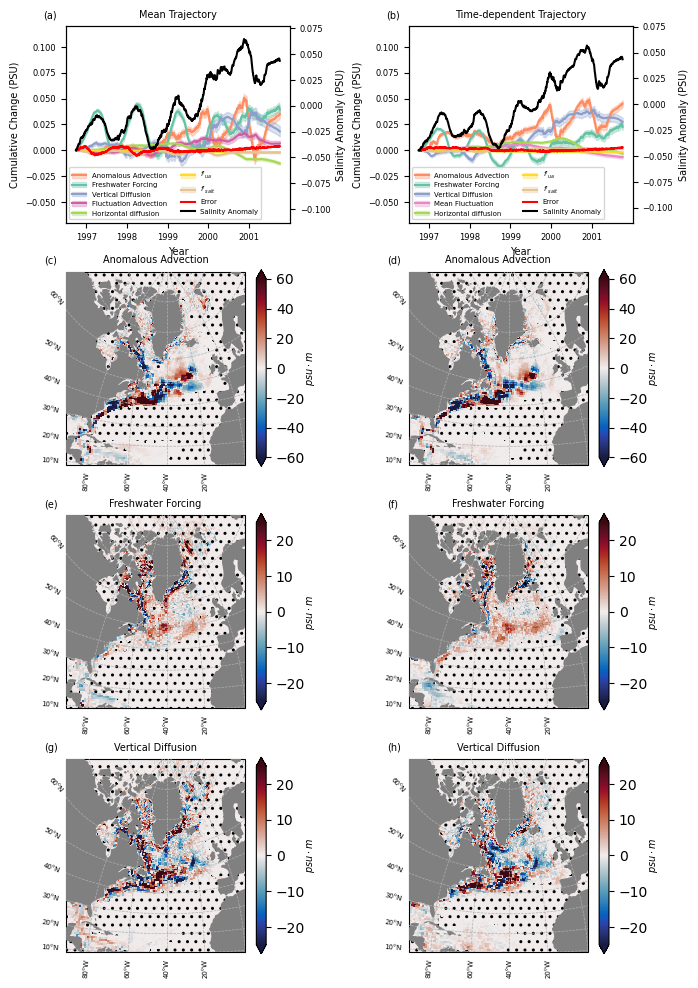

In [13]:
fig = plt.figure(figsize = (180*mm,254*mm))
axs = [
    plt.subplot(4,2,i+1) for i in range(2)
      ]+[
    plt.subplot(4,2,i+1, projection = projection) for i in range(2,8)
      ]
case = 'neutral2001'
if 'fresh' in case:
    node = 4
else:
    node = 8
vol_each = 558514510387999.06/45336

for i,traj_typ in enumerate(['mean','time']):
    labels,handles = create_line_plot(axs[i],case,traj_typ,ylim = (-0.07,0.12))
    axs[i].legend(handles,labels,fontsize = 5,ncol = 2)
    axs[i].set_title(f'({chr(97+i)})',loc = 'left',x = -0.1,fontsize = 7)
    axs[i].set_title(['Mean Trajectory','Time-dependent Trajectory'][i],fontsize = 7)

for j,traj_typ in enumerate(['mean','time']):
    for i,var in enumerate(['A','F','dif_v']):
        hash_type = 'wholedepth'
        vmax = 25
        if var == 'F':
            hash_type = 'surface'
        if var =='A':
            vmax = 60
        ax = axs[2*i+j+2]
        maps = xr.open_zarr(f'/sciserver/filedb0{node}-01/ocean/wenrui_temp/particle_file/{case}/{traj_typ}_traj_maps/')
        plot2d(maps,var,vol_each,ax = ax,vmax = vmax,hash_type = hash_type,title = case_term_dic[var],ind = 2*i+j+2)
plt.tight_layout()
plt.subplots_adjust(hspace = 0.24,wspace = 0.53)    
plt.savefig(f'{case}_comparison.pdf',dpi = 300)

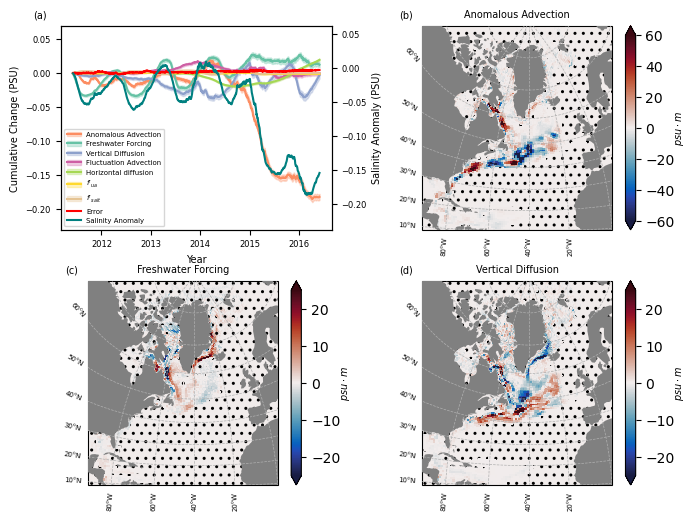

In [14]:
fig = plt.figure(figsize = (180*mm,135*mm))
axs = [
    plt.subplot(2,2,i+1) for i in range(1)
      ]+[
    plt.subplot(2,2,i+1, projection = projection) for i in range(1,4)
      ]
case = 'fresh'
traj_typ = 'mean'
if 'fresh' in case:
    node = 4
else:
    node = 8
if case == 'salty':
    VOLUME_TOTAL,NUMBER_OF_PARTICLE,idate = TOTAL_VOLUME_salty,50109,salty_idate
elif case == 'fresh':
    VOLUME_TOTAL,NUMBER_OF_PARTICLE,idate = TOTAL_VOLUME_fresh,49998,fresh_idate
vol_each = VOLUME_TOTAL/NUMBER_OF_PARTICLE

labels,handles = create_line_plot(axs[0],case,traj_typ,ylim = (-0.23,0.07))
axs[0].legend(handles,labels,fontsize = 5)
axs[0].set_title('(a)',loc = 'left',x = -0.1,fontsize = 7)

maps = xr.open_zarr(f'/sciserver/filedb0{node}-01/ocean/wenrui_temp/particle_file/{case}M/{traj_typ}_traj_maps/')
for i,var in enumerate(['A','F','dif_v']):
    hash_type = 'wholedepth'
    vmax = 25
    if var == 'F':
        hash_type = 'surface'
    if var =='A':
        vmax = 60
    ax = axs[i+1]
    plot2d(maps,var,vol_each,ax = ax,vmax = vmax,hash_type = hash_type,title = case_term_dic[var],ind = i+1)
plt.tight_layout()
plt.subplots_adjust(hspace = 0.25)
plt.savefig(f'{case}_mean_traj.pdf',dpi = 300)

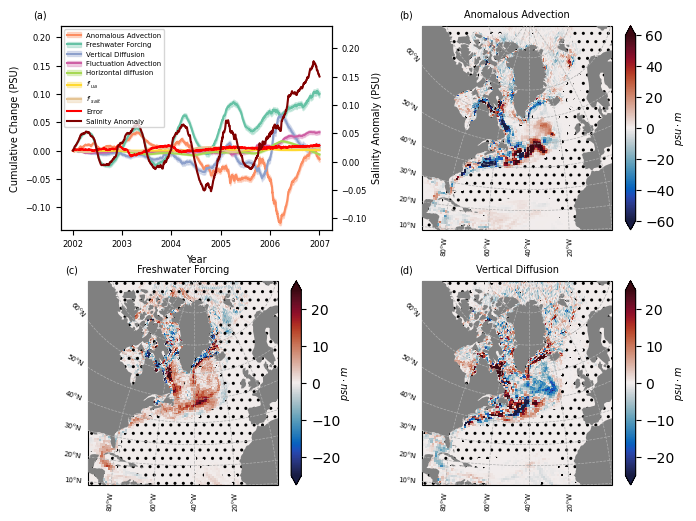

In [15]:
fig = plt.figure(figsize = (180*mm,135*mm))
axs = [
    plt.subplot(2,2,i+1) for i in range(1)
      ]+[
    plt.subplot(2,2,i+1, projection = projection) for i in range(1,4)
      ]
case = 'salty'
traj_typ = 'mean'
if 'fresh' in case:
    node = 4
else:
    node = 8
if case == 'salty':
    VOLUME_TOTAL,NUMBER_OF_PARTICLE,idate = TOTAL_VOLUME_salty,50109,salty_idate
elif case == 'fresh':
    VOLUME_TOTAL,NUMBER_OF_PARTICLE,idate = TOTAL_VOLUME_fresh,49998,fresh_idate
vol_each = VOLUME_TOTAL/NUMBER_OF_PARTICLE

labels,handles = create_line_plot(axs[0],case,traj_typ,ylim = (-0.14,0.22))
axs[0].legend(handles,labels,fontsize = 5)
axs[0].set_title('(a)',loc = 'left',x = -0.1,fontsize = 7)

maps = xr.open_zarr(f'/sciserver/filedb0{node}-01/ocean/wenrui_temp/particle_file/{case}M/{traj_typ}_traj_maps/')
for i,var in enumerate(['A','F','dif_v']):
    hash_type = 'wholedepth'
    vmax = 25
    if var == 'F':
        hash_type = 'surface'
    if var =='A':
        vmax = 60
    ax = axs[i+1]
    plot2d(maps,var,vol_each,ax = ax,vmax = vmax,hash_type = hash_type,title = case_term_dic[var],ind = i+1)
plt.tight_layout()
plt.subplots_adjust(hspace = 0.25)
plt.savefig(f'{case}_mean_traj.pdf',dpi = 300)